In [36]:
!pip install ta --quiet

In [37]:
# Imports

# Essential libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilties
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import precision_recall_fscore_support

# Set up matplotlib for inline display
%matplotlib inline

In [38]:
# Get raw data

# Time range: past year
end_date = datetime.now()
start_date = end_date - timedelta(days=3650)

# Download data and include adjusted close
amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Get P/E ratio
amzn = yf.Ticker("AMZN")
eps = amzn.info.get('trailingEps', np.nan)
amzn_data['PE_Ratio'] = amzn_data['Adj Close'] / eps

# Check available columns
print("Columns:", amzn_data.columns)

# Daily Volatility (using 7-day rolling standard deviation of log returns)
amzn_data['Log_Return'] = (amzn_data['Adj Close'] / amzn_data['Adj Close'].shift(1)).apply(np.log)
amzn_data['Volatility_7d'] = amzn_data['Log_Return'].rolling(window=7).std()

# MA past week
amzn_data['MA_7'] = amzn_data['Adj Close'].rolling(window=7).mean()
# MA past month
amzn_data['MA_30'] = amzn_data['Adj Close'].rolling(window=30).mean()
# MA past year
amzn_data['MA_365'] = amzn_data['Adj Close'].rolling(window=365).mean()
# Daily Percent change
amzn_data['Pct_Change'] = amzn_data['Adj Close'].pct_change()
# Simulated sentiment based on daily percent change
amzn_data['Sentiment'] = amzn_data['Log_Return'].apply(
    lambda x: 1 if x > 0 else 0)

# Remove multi-index
amzn_data.columns = [col[0] if isinstance(col, tuple) else col for col in amzn_data.columns]
print("Columns:", amzn_data.columns)

# Display last few rows
print(amzn_data.tail())

[*********************100%***********************]  1 of 1 completed


Columns: MultiIndex([('Adj Close', 'AMZN'),
            (    'Close', 'AMZN'),
            (     'High', 'AMZN'),
            (      'Low', 'AMZN'),
            (     'Open', 'AMZN'),
            (   'Volume', 'AMZN'),
            ( 'PE_Ratio',     '')],
           names=['Price', 'Ticker'])
Columns: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'PE_Ratio',
       'Log_Return', 'Volatility_7d', 'MA_7', 'MA_30', 'MA_365', 'Pct_Change',
       'Sentiment'],
      dtype='object')
             Adj Close       Close        High         Low        Open  \
Date                                                                     
2025-04-23  180.600006  180.600006  187.380005  180.190002  183.449997   
2025-04-24  186.539993  186.539993  186.740005  180.179993  180.919998   
2025-04-25  188.990005  188.990005  189.940002  185.490005  187.619995   
2025-04-28  187.699997  187.699997  190.220001  184.889999  190.110001   
2025-04-29  186.820007  186.820007  187.440002  183.679993

In [39]:
# Adjust data for logistic regression

# Drop unecessary columns
amzn_data = amzn_data.drop(['Close', 'High', 'Low', 'Open', "Pct_Change"], axis=1)

# Distance Close vs MA_7
amzn_data['Close vs MA_7'] = (amzn_data['Adj Close'] - amzn_data['MA_7']) / amzn_data['MA_7']
amzn_data['Close vs MA_7'] *= 100
# Distance MA_7 to MA_30
amzn_data['MA_7 vs MA_30'] = (amzn_data['MA_7'] - amzn_data['MA_30']) / amzn_data['MA_30']
amzn_data['MA_7 vs MA_30'] *= 100
# Distance MA_30 to MA_365
amzn_data['MA_30 vs MA_365'] = (amzn_data['MA_30'] - amzn_data['MA_365']) / amzn_data['MA_365']
amzn_data['MA_30 vs MA_365'] *= 100
amzn_data = amzn_data.drop(['MA_7', 'MA_30', 'MA_365'], axis=1)

# Normalize volume by 30-day average volume
amzn_data['Avg_Volume_30d'] = amzn_data['Volume'].rolling(window=30).mean()
amzn_data['Volume_Normalized_30d'] = amzn_data['Volume'] / amzn_data['Avg_Volume_30d']
amzn_data = amzn_data.drop(['Volume', 'Avg_Volume_30d'], axis=1)

# Log_Return for past 4 days
amzn_data['Log_Return_-1'] = np.log(amzn_data['Adj Close'].shift(1) / amzn_data['Adj Close'].shift(2))
amzn_data['Log_Return_-2'] = np.log(amzn_data['Adj Close'].shift(2) / amzn_data['Adj Close'].shift(3))
amzn_data['Log_Return_-3'] = np.log(amzn_data['Adj Close'].shift(3) / amzn_data['Adj Close'].shift(4))
amzn_data['Log_Return_-4'] = np.log(amzn_data['Adj Close'].shift(4) / amzn_data['Adj Close'].shift(5))

# Create 5-day momentum
amzn_data['5_Day_Momentum'] = amzn_data['Adj Close'] / amzn_data['Adj Close'].shift(4)

# Normalize P/E ratio by historical median
pe_median = amzn_data['PE_Ratio'].median()
amzn_data['PE_Ratio_Normalized'] = amzn_data['PE_Ratio'] / pe_median
amzn_data = amzn_data.drop(['PE_Ratio'], axis=1)

# Create 14-day RSI
delta = amzn_data['Adj Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean()
rs = avg_gain / avg_loss
amzn_data['RSI_14'] = 100 - (100 / (1 + rs)).shift(1)

# Tomorrow's log return
amzn_data['Tomorrow_Log_Return'] = amzn_data['Log_Return'].shift(-1)

# MACD calculation
# 12-day EMA of Adjusted Close
ema_12 = amzn_data['Adj Close'].ewm(span=12, adjust=False).mean()

# 26-day EMA of Adjusted Close
ema_26 = amzn_data['Adj Close'].ewm(span=26, adjust=False).mean()

# MACD Line
amzn_data['MACD_Line'] = ema_12 - ema_26

# Signal Line (9-day EMA of MACD Line)
amzn_data['MACD_Signal'] = amzn_data['MACD_Line'].ewm(span=9, adjust=False).mean()

# MACD Histogram (MACD Line - Signal Line)
amzn_data['MACD_Histogram'] = amzn_data['MACD_Line'] - amzn_data['MACD_Signal']

amzn_data = amzn_data.drop(['Adj Close'], axis=1)

In [40]:
amzn_data.describe()

,Log_Return,Volatility_7d,Sentiment,Close vs MA_7,MA_7 vs MA_30,MA_30 vs MA_365,Volume_Normalized_30d,Log_Return_-1,Log_Return_-2,Log_Return_-3,Log_Return_-4,5_Day_Momentum,PE_Ratio_Normalized,RSI_14,Tomorrow_Log_Return,MACD_Line,MACD_Signal,MACD_Histogram
count,2512.000000,2506.000000,2513.000000,2507.000000,2484.000000,2149.000000,2484.000000,2511.000000,2510.000000,2509.000000,2508.000000,2509.000000,2513.000000,2498.000000,2512.000000,2513.000000,2513.000000,2513.000000
mean,0.000867,0.017871,0.533625,0.273234,1.028487,15.450224,1.009032,0.000869,0.000872,0.000868,0.000855,1.004305,1.100980,54.891531,0.000867,0.465730,0.474229,-0.008499
std,0.020643,0.010533,0.498967,2.746279,4.646420,20.312814,0.413450,0.020647,0.020651,0.020653,0.020648,0.040404,0.566225,16.363504,0.020643,2.573137,2.403028,0.796498
min,-0.151398,0.001943,0.000000,-13.091996,-20.529267,-36.295027,0.255631,-0.151398,-0.151398,-0.151398,-0.151398,0.830209,0.214862,11.435317,-0.151398,-12.431501,-10.695326,-3.317492
25%,-0.008853,0.010569,0.000000,-1.144719,-1.363043,5.836639,0.753513,-0.008860,-0.008867,-0.008874,-0.008883,0.983413,0.560980,43.175527,-0.008853,-0.529010,-0.445206,-0.319467
50%,0.001125,0.015381,1.000000,0.397532,1.483027,17.068577,0.913803,0.001142,0.001142,0.001142,0.001125,1.004840,1.000000,55.509496,0.001125,0.532758,0.534729,0.006946
75%,0.011506,0.022269,1.000000,1.782346,3.872529,29.210253,1.135142,0.011510,0.011513,0.011502,0.011431,1.026699,1.621086,66.530577,0.011506,1.838543,1.713765,0.338372
max,0.126949,0.067685,1.000000,10.759400,17.000037,52.804599,5.809082,0.126949,0.126949,0.126949,0.126949,1.179253,2.481967,93.978391,0.126949,8.333275,7.262579,3.392966


In [41]:
amzn_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2015-05-04 to 2025-04-29
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Log_Return             2512 non-null   float64
 1   Volatility_7d          2506 non-null   float64
 2   Sentiment              2513 non-null   int64  
 3   Close vs MA_7          2507 non-null   float64
 4   MA_7 vs MA_30          2484 non-null   float64
 5   MA_30 vs MA_365        2149 non-null   float64
 6   Volume_Normalized_30d  2484 non-null   float64
 7   Log_Return_-1          2511 non-null   float64
 8   Log_Return_-2          2510 non-null   float64
 9   Log_Return_-3          2509 non-null   float64
 10  Log_Return_-4          2508 non-null   float64
 11  5_Day_Momentum         2509 non-null   float64
 12  PE_Ratio_Normalized    2513 non-null   float64
 13  RSI_14                 2498 non-null   float64
 14  Tomorrow_Log_Return    2512 non-null  

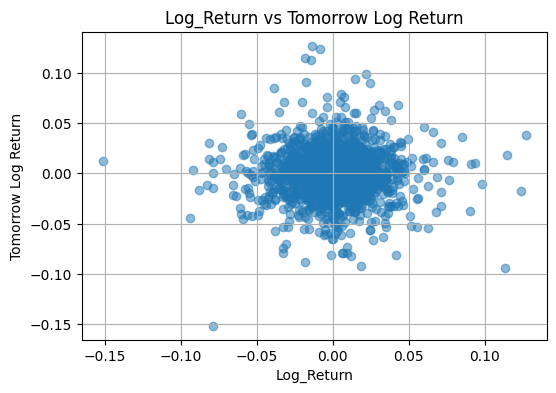

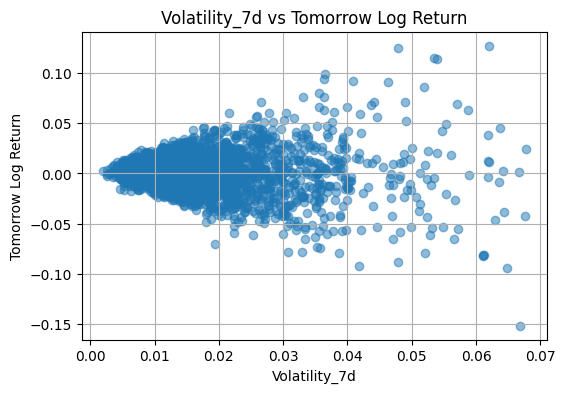

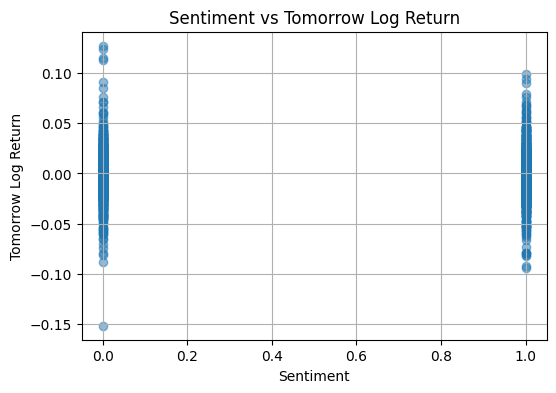

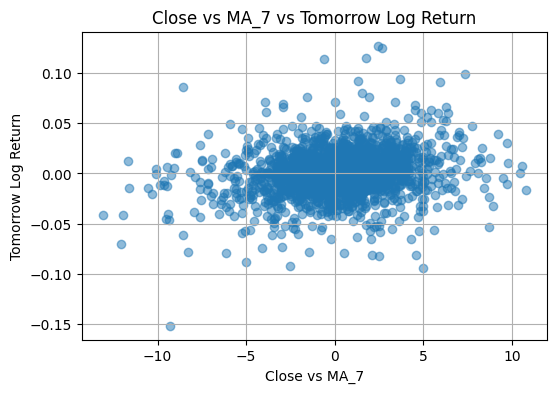

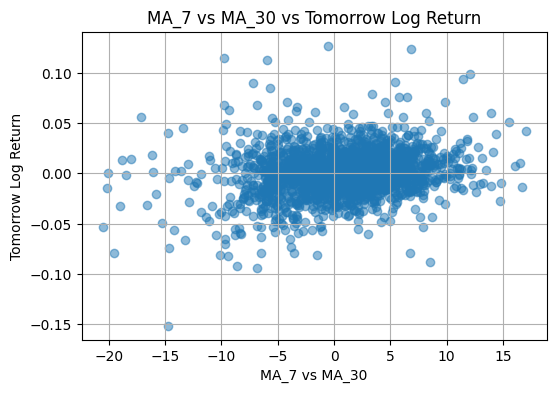

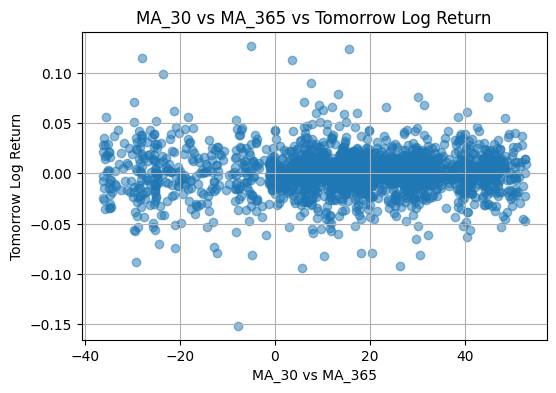

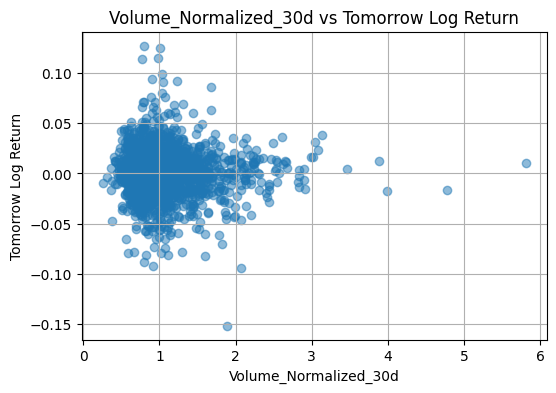

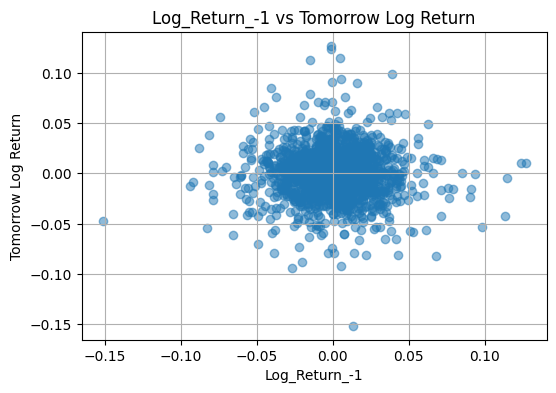

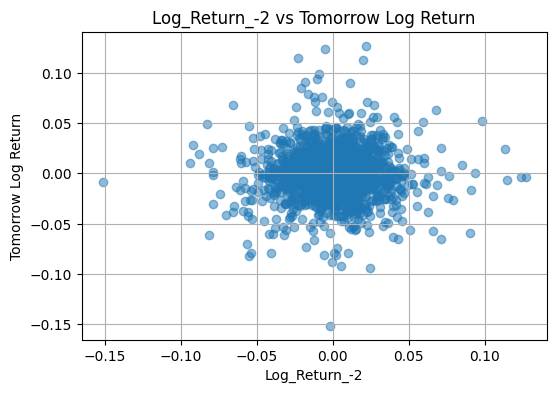

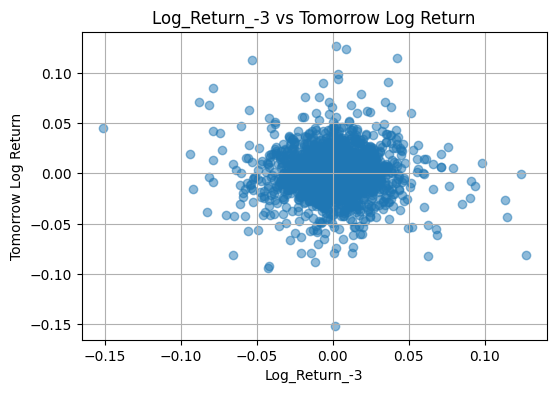

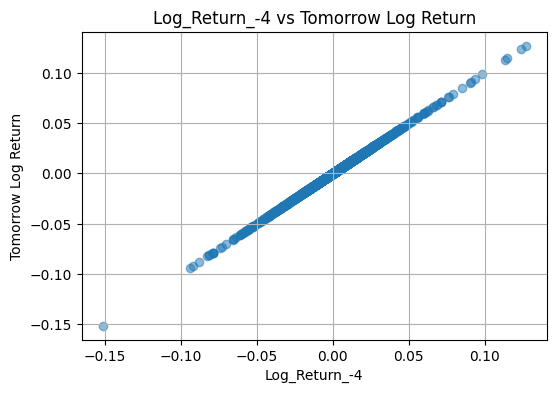

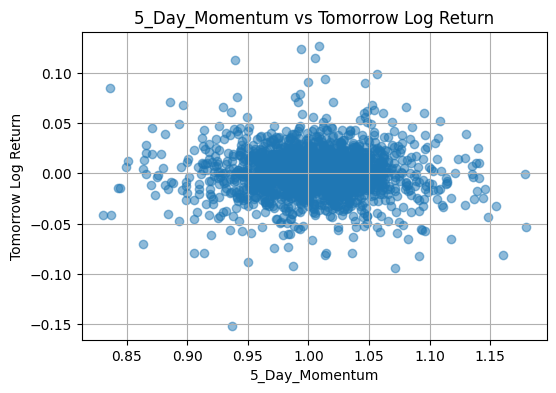

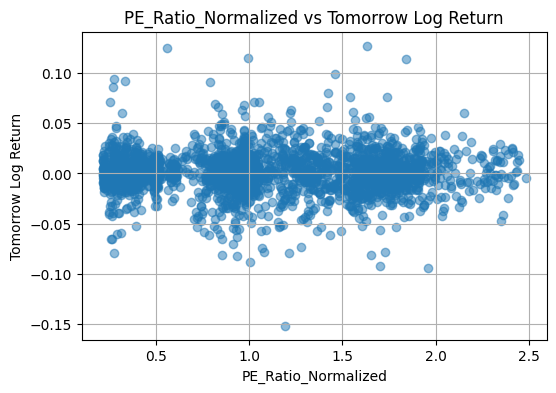

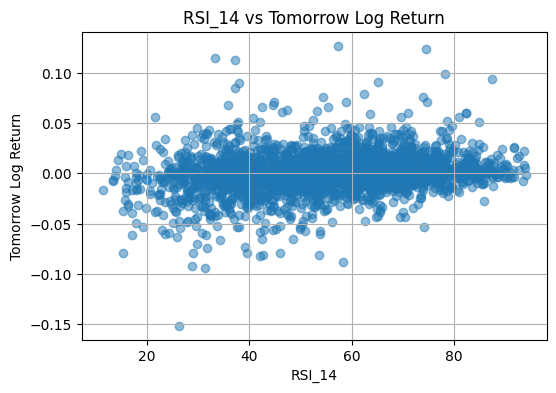

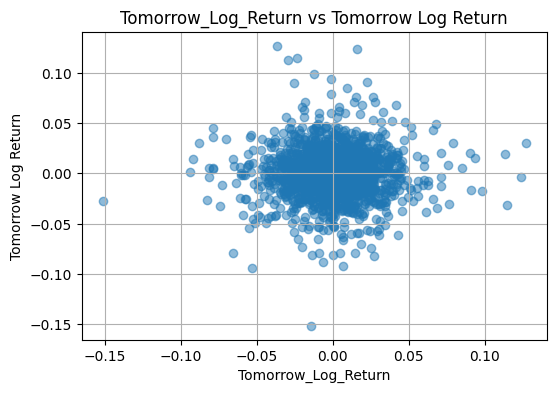

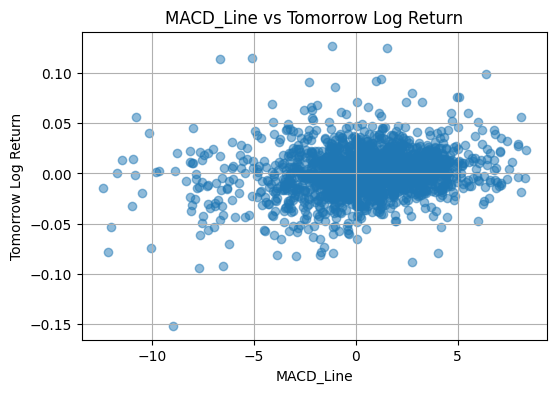

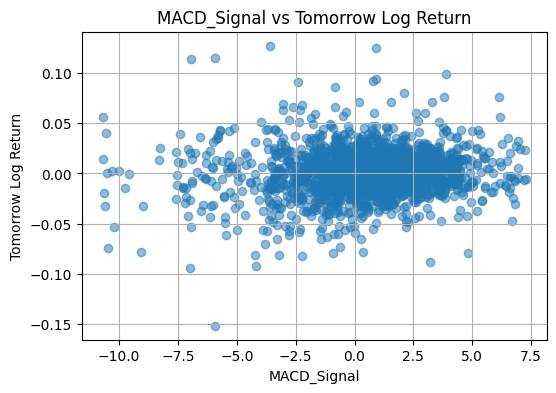

<bound method NDFrame.tail of             Log_Return  Volatility_7d  Sentiment  Close vs MA_7  \
Date                                                              
2015-05-04         NaN            NaN          0            NaN   
2015-05-05   -0.004383            NaN          0            NaN   
2015-05-06   -0.004974            NaN          0            NaN   
2015-05-07    0.018393            NaN          1            NaN   
2015-05-08    0.015827            NaN          1            NaN   
...                ...            ...        ...            ...   
2025-04-23    0.041953       0.029547          1       2.801386   
2025-04-24    0.032361       0.031772          1       5.802276   
2025-04-25    0.013048       0.030934          1       6.381630   
2025-04-28   -0.006849       0.027376          0       4.531638   
2025-04-29   -0.004699       0.026790          0       2.878499   

            MA_7 vs MA_30  MA_30 vs MA_365  Volume_Normalized_30d  \
Date                         

In [42]:
# Plot Relationship between each feature and Tomorrow_Log_Return
# Loop through all features except the target
for i in range(amzn_data.shape[1]-1):   # skip the last column
    feature = amzn_data.columns[i]
    plt.figure(figsize=(6, 4))
    plt.scatter(amzn_data[feature], amzn_data.iloc[:, 10], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Tomorrow Log Return')
    plt.title(f'{feature} vs Tomorrow Log Return')
    plt.grid(True)
    plt.show()

print(amzn_data.tail)


In [43]:
# Get feature (X) and target matrix (y)

# 3 years of data
days = 1095

X = amzn_data.iloc[-(days+5):-5]
X = X.drop(['Sentiment', 'Tomorrow_Log_Return'], axis=1)
print("X.shape:", X.shape)

y = amzn_data['Tomorrow_Log_Return'].iloc[-(days+5):-5]
y = y.apply(lambda x: 1 if x > 0 else 0)

print("y.shape:", y.shape)

print(X.tail)
print(y.tail)

X.shape: (1095, 16)
y.shape: (1095,)
<bound method NDFrame.tail of             Log_Return  Volatility_7d  Close vs MA_7  MA_7 vs MA_30  \
Date                                                                  
2020-12-10   -0.000873       0.009060      -1.735285       0.307827   
2020-12-11    0.004802       0.009845      -0.871416       0.012557   
2020-12-14    0.012928       0.011669       0.554397      -0.250491   
2020-12-15    0.002578       0.011389       0.802338      -0.408395   
2020-12-16    0.023679       0.014381       2.829562      -0.235588   
...                ...            ...            ...            ...   
2025-04-15   -0.013989       0.053856      -0.607993      -5.928606   
2025-04-16   -0.029726       0.054803      -3.448084      -5.439332   
2025-04-17   -0.009915       0.053846      -4.547968      -4.826732   
2025-04-21   -0.031127       0.022598      -5.701814      -6.088598   
2025-04-22    0.034423       0.024697      -1.763346      -6.343566   

         

In [44]:
# Split the data using train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Scale the data

scale = StandardScaler()
# scale both the training and test data using the fitted scaler.
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
# X_test = scale.fit_transform(X_test)

# Reshape `y_train` into 2D array, and `y_test` into 2D array
y_2d_train = y_train.to_numpy().reshape(-1,1)
y_2d_train = y_2d_train.reshape(y_2d_train.shape[0], 1)
y_2d_test = y_test.to_numpy().reshape(-1,1)
y_2d_test = y_2d_test.reshape(y_2d_test.shape[0], 1)

print("X_train.shape:", X_train.shape)
print("y_2d_train.shape:", y_2d_train.shape)

X_train.shape: (876, 16)
y_2d_train.shape: (876, 1)


In [46]:
# Appending a column of ones to X_train

ones = np.ones((X_train.shape[0], 1))
X_train_1 = np.hstack((ones, X_train))
print("The trainng data has dimensions: ", X_train_1.shape)

The trainng data has dimensions:  (876, 17)


In [47]:
# Write the sigmoid function
def sigmoid(z):
    result = 1 / (1 + np.exp(-z))
    return result

In [48]:
# Initialize w_init to a zero matrix with shape (X_train_1.shape[1],1)
w_init = np.zeros((X_train_1.shape[1],1))
print(w_init.shape)

(17, 1)


In [49]:
# Write the hypothesis function which assumes the design matrix X is augmented with a column of ones
def hypothesis(X, w):
    result = sigmoid(X.dot(w))
    return result

In [50]:
# Compute y_hat(<np.ndarray>) using your hypotheis function with X_train_1 and w_init (w_init is still set to zero).
# This is just a preliminary test of the hypotheis function
y_hat_init = hypothesis(X_train_1,w_init)

# Verify
print('y_hat_init: ', y_hat_init)

y_hat_init:  [[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]


In [51]:
# Write the log likelihood function
def log_likelihood(X, y, w):
    h = hypothesis(X, w)
    result = np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return result # you should return a real number, not a list containing a real number

In [52]:
# Quick check of log_likelihood function
print('log likelihood: ', log_likelihood(X_train_1, y_2d_train, w_init))

log likelihood:  -607.1969301705121


In [53]:
# Write the gradient ascent function

def Gradient_Ascent(X, y, learning_rate, num_iters):
    # We assume X has been augmented with a column of ones

    # Number of training examples.
    N = X.shape[0]

    # Initialize w(<np.ndarray>). Zeros vector of shape X.shape[1],1
    w = np.zeros((X.shape[1],1))

    # Initiating list to store values of likelihood(<list>) after few iterations.
    log_likelihood_values = []

    # Gradient Ascent - local optimization technique
    for i in range(num_iters):
        h = hypothesis(X, w)
        error = y -h
        gradient = (X.T).dot(error)
        w += learning_rate * (gradient/N)
        # Computing log likelihood of seeing examples for current value of w
        if (i % 10) == 0:
            log_likelihood_values.append(log_likelihood(X, y, w))
            print(log_likelihood(X, y, w))

    return w, log_likelihood_values

In [54]:
# Try many different values for the learning rate (including very small values).

learning_rate = 0.1
num_iters = 10000
# Calculate w and likelihood values using Gradient_Ascent with X_train_1, y_2d_train
w, log_likelihood_values = Gradient_Ascent(X_train_1, y_2d_train, learning_rate, num_iters)
print(w, log_likelihood_values)

-606.9758948373349
-605.7415875858703
-605.1310852115517
-604.7316593031453
-604.4501008127374
-604.2430941046737
-604.0853804291351
-603.961371208109
-603.8611611686159
-603.7782892024923
-603.708427131201
-603.6485961155265
-603.5966901782524
-603.551181256024
-603.510933109324
-603.4750815059454
-603.4429554181052
-603.414024056334
-603.387860492803
-603.3641161519515
-603.3425025672262
-603.322778095823
-603.3047380834196
-603.2882074740619
-603.273035182433
-603.2590897557524
-603.2462559921507
-603.2344322769274
-603.2235284633557
-603.2134641705061
-603.2041674032179
-603.1955734229782
-603.1876238157474
-603.1802657155642
-603.173451152314
-603.1671364992122
-603.1612820010064
-603.1558513680279
-603.150811424403
-603.1461318011645
-603.1417846668953
-603.1377444899892
-603.1339878277612
-603.1304931385274
-603.1272406134788
-603.1242120257252
-603.1213905943331
-603.1187608615269
-603.116308581514
-603.1140206196178
-603.1118848605986
-603.1098901251851
-603.1080260939793
-603

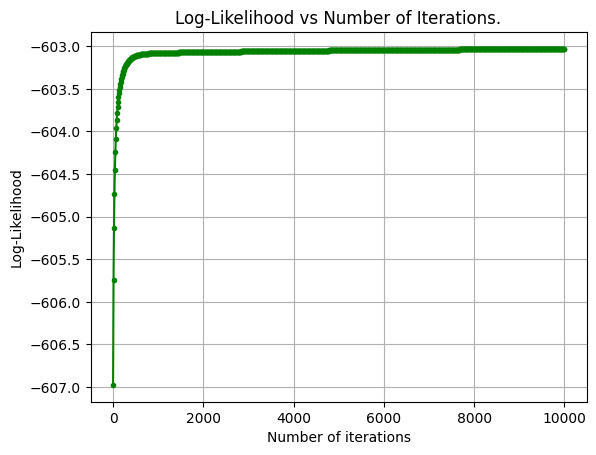

In [55]:
# Plot Likelihood v/s Number of Iterations.
iters = np.array(range(0,num_iters,10))
plt.plot(iters,log_likelihood_values,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Log-Likelihood')
plt.title("Log-Likelihood vs Number of Iterations.")
plt.grid()
plt.show(block=False)

In [56]:
# Given a set of examples write the function to compute predicted which class for each example: 0 if the probability of belonging to class  is < t and returns 1 otherwise)
def predict_class(X, w, t):
    h = hypothesis(X, w)

    return (h >= t).astype(int).reshape(h.shape)

In [57]:
# Predict the class y_hat using X_test and w that was just calculated if the threshold is t = 0.0

# First augment the test dataset with a column of ones.
ones = np.ones((X_test.shape[0], 1))
X_test_1 = np.hstack((ones, X_test))
# Now predict the label of each example in your test set
y_hat = predict_class(X_test_1, w, t=0.5)
print(y_hat)

[[1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]


In [58]:
# Precision_recall function that calculates: false_pos, false_neg and true_pos.  These numbers will be used to calculate precision and recall
def precision_recall(y_hat, y, threshold):

    # Calculate false positive and false negative
    false_pos = sum((y_hat[i] == 1 and y[i] == 0) for i in range(len(y)))
    false_neg = sum((y_hat[i] == 0 and y[i] == 1) for i in range(len(y)))

    # Calculate true positive an true_pos should be 88
    true_pos = sum((y_hat[i] == 1 and y[i] == 1) for i in range(len(y)))
    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/(true_pos + false_neg)

    # true_neg = y_hat.shape[0] - false_pos - false_neg - true_pos
    # print(true_pos, true_neg, false_neg, false_pos)

    return precision,recall

In [59]:
# Calculate precision and recall using on the test data where the threshold is 0.0

precision, recall = precision_recall(y_hat, y_test, threshold=0.0)

print('Q14 - precision: ', precision)
print('Q14 - recall: ', recall)

Q14 - precision:  [0.49295775]
Q14 - recall:  [0.65420561]


<ipython-input-58-05c9993c9111>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  false_pos = sum((y_hat[i] == 1 and y[i] == 0) for i in range(len(y)))
<ipython-input-58-05c9993c9111>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  false_neg = sum((y_hat[i] == 0 and y[i] == 1) for i in range(len(y)))
<ipython-input-58-05c9993c9111>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_pos = sum((y_hat[i] == 1 and y[i] == 1) for i in

In [60]:
# Write the F1_score function
def f1_score(precision, recall):
    result = 2*(precision*recall)/(precision+recall)
    return result

In [61]:
# Computing the F1 score on the test data set using the precision and recall you computed above.
f1_score_noreg = f1_score(precision, recall)
print("F1 score (no reg):", f1_score_noreg)

F1 score (no reg): [0.562249]


In [62]:
# Use sklearn's logistic regression model which includes regualarization parameter
# Create object of logistic regression model. Penalty = none or set to large value to make lambda (C = 1/lambda) nearly 0.
logreg = linear_model.LogisticRegression(penalty = None)

In [63]:
# Fit the model
# Don't use matrix X_train_1. Instead, use X_train.
logreg.fit(X_train, y_train )

LogisticRegression(penalty=None)

In [64]:
# Print out all the coefficients
w_logreg = logreg.coef_
intercept_logreg = logreg.intercept_

print('w_logreg: ', w_logreg)
print('ntercept_logreg: ', intercept_logreg)

w_logreg:  [[-0.33707932 -0.10369224 -0.17828566  0.03855664  0.16686914  0.00297997
  -0.39196523 -0.44018106 -0.44478928  0.02799992  0.91788196 -0.22422604
  -0.09541792 -0.00578662 -0.02078456  0.04328936]]
ntercept_logreg:  [0.05952968]


In [65]:
# Find the predicted values on test set (X_test not X_test_1) using logreg.predict
y_hat_logreg = logreg.predict(X_test)

# Find the accuracy achieved on test set using logreg.score and y_test
acc_logreg = logreg.score(X_test, y_test)

print("Accuracy on training data = %f" % acc_logreg)

Accuracy on training data = 0.497717


In [66]:
# Find Precision, recall and fscore using precision_recall_fscore_support method of sklearn
# Using y_test and y_hat_logreg
prec, recal, fscore, sup = precision_recall_fscore_support(y_test, y_hat_logreg)

print('prec: ', prec)
print('recal: ', recal)
print('fscore: ', fscore)

prec:  [0.51315789 0.48951049]
recal:  [0.34821429 0.65420561]
fscore:  [0.41489362 0.56      ]


In [70]:
# Test model with regularization, from C=6 (lambda = 0.000001) to C = 0 (lambda = 1)

# Initalize range from 1 to 10e6
reg_params = np.logspace(0, 6, num=7)

# Train and test model with each regularization value
for C in reg_params[::-1]:
    logreg = linear_model.LogisticRegression(penalty = 'l2', C = C)
    logreg.fit(X_train, y_train )

    w_logreg = logreg.coef_
    intercept_logreg = logreg.intercept_

    y_hat_logreg = logreg.predict(X_test)
    acc_logreg = logreg.score(X_test, y_test)
    print("Accuracy on training data (C =", C, ":", acc_logreg)

Accuracy on training data (C = 1000000.0 : 0.4977168949771689
Accuracy on training data (C = 100000.0 : 0.4977168949771689
Accuracy on training data (C = 10000.0 : 0.4977168949771689
Accuracy on training data (C = 1000.0 : 0.502283105022831
Accuracy on training data (C = 100.0 : 0.5068493150684932
Accuracy on training data (C = 10.0 : 0.5068493150684932
Accuracy on training data (C = 1.0 : 0.5114155251141552
